In [4]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
image_dir = "Data/images"

data = pd.read_csv("Data/metadata.csv")
data_uni = data.drop_duplicates()


/tmp/ipykernel_741/1466725315.py:3: DtypeWarning: Columns (8,13,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Data/metadata.csv")


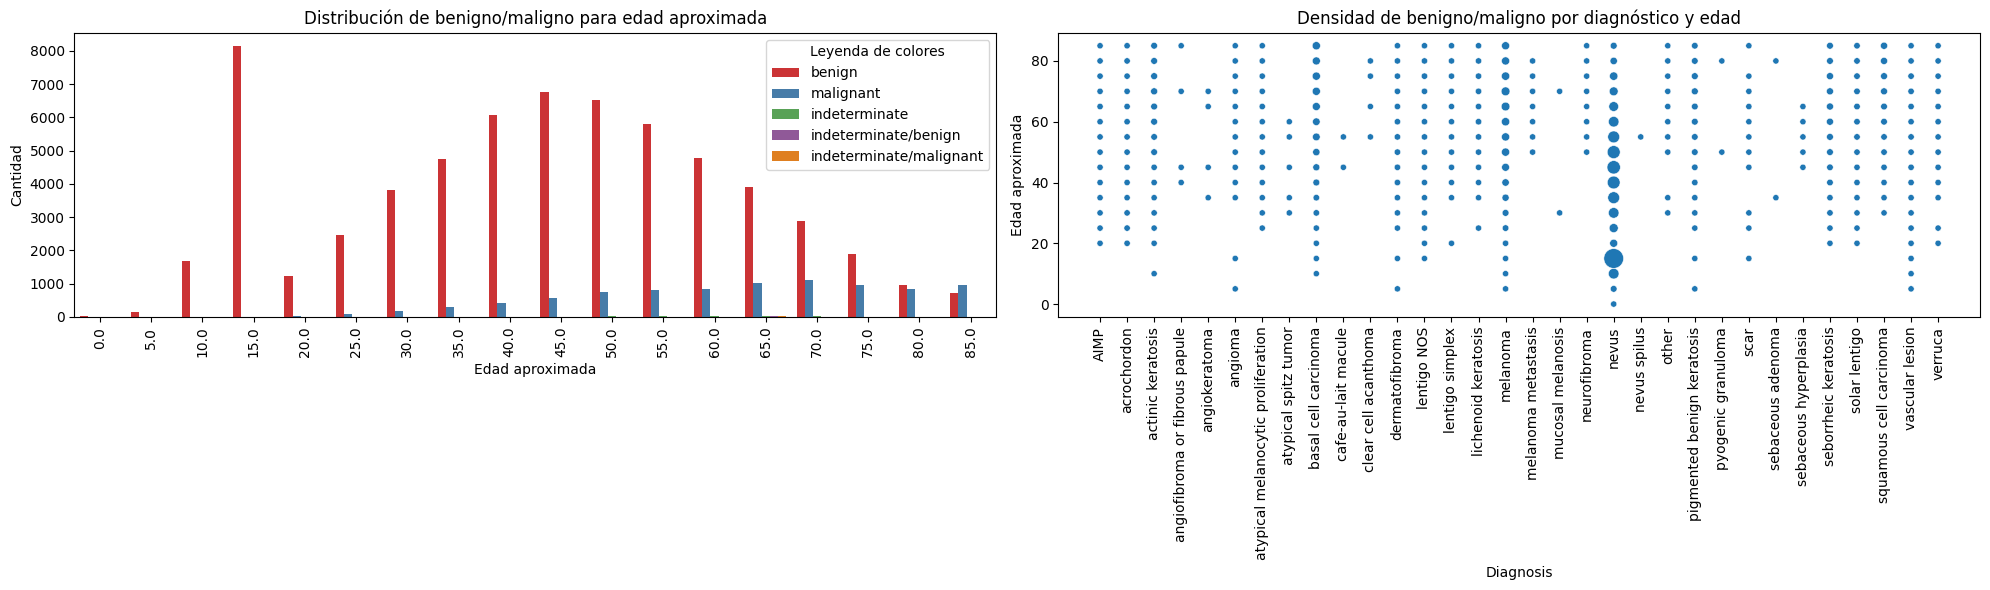

In [6]:
categorical_cols = ["diagnosis", "age_approx"]
def plot_distribution(data, categorical_columns, target_column):
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 6))
    
    col1 = categorical_columns[1]
    sns.countplot(data = data, x = col1, hue = target_column, palette = 'Set1', ax = axes[0])
    axes[0].set_title(f'Distribución de benigno/maligno para edad aproximada')
    axes[0].set_xlabel("Edad aproximada")
    axes[0].set_ylabel('Cantidad')
    axes[0].legend(title = "Leyenda de colores")
    axes[0].tick_params(axis = 'x', rotation = 90)
    
    col2 = "age_approx"
    density_data = data.groupby(['diagnosis', col2]).size().reset_index(name = 'count')
    sns.scatterplot(data = density_data, x = 'diagnosis', y = col2, size = 'count', sizes = (20, 200), legend = False, ax = axes[1])
    axes[1].set_title(f'Densidad de benigno/maligno por diagnóstico y edad')
    axes[1].set_xlabel('Diagnosis')
    axes[1].set_ylabel('Edad aproximada')
    axes[1].tick_params(axis = 'x', rotation = 90)
    
    plt.tight_layout()
    plt.show()

plot_distribution(data_uni, categorical_cols, 'benign_malignant')

In [ ]:
print(data_uni.size)
data_uni = data_uni[
    data_uni["benign_malignant"].isin(["benign", "malignant"])
]


data_uni["filename"] = data_uni["isic_id"] + ".jpg"

data_uni["label"] = data_uni["benign_malignant"]

data_uni["label_index"] = data_uni["label"].astype("category").cat.codes
label_names = data_uni["label"].astype("category").cat.categories.tolist()

print(f"Diagnosis {label_names}")


2288216
Diagnosis ['benign', 'malignant']


/tmp/ipykernel_587/24424626.py:3: DtypeWarning: Columns (8,13,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Data/metadata.csv")


In [42]:

data_uni["filepath"] = data_uni["filename"].apply(lambda fname: os.path.join(image_dir, fname))
data_uni = data_uni[data_uni["filepath"].apply(os.path.exists)]



In [4]:

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()



I0000 00:00:1749811037.092921     587 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,594,369 (21.34 MB)

 Trainable params: 5,594,369 (21.34 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
df_benign = data_uni[data_uni['label_index'] == 0]
df_malignant = data_uni[data_uni['label_index'] == 1]

In [61]:
data_uni["label_str"] = data_uni["label_index"].map({0: "benign", 1: "malignant"})

df_malignant_upsampled = resample(
    df_malignant,
    replace=True,
    n_samples=len(df_benign),
    random_state=42
)

balanced_df = pd.concat([df_benign, df_malignant_upsampled])

balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% para validación
)

train_generator_bal = train_datagen.flow_from_dataframe(
    dataframe=balanced_df,
    x_col='filepath',
    y_col='label_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator_bal = train_datagen.flow_from_dataframe(
    dataframe=balanced_df,
    x_col='filepath',
    y_col='label_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 102476 validated image filenames belonging to 2 classes.
Found 25618 validated image filenames belonging to 2 classes.


In [23]:
model.fit(
    train_generator_bal,
    validation_data=val_generator_bal,
    epochs=10,
    # class_weight=class_weights_manual,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
)

/home/salvikc/tf-ubuntu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 3409s 1s/step - accuracy: 0.7441 - loss: 0.5088 - val_accuracy: 0.7549 - val_loss: 0.5020 - learning_rate: 1.0000e-05
Epoch 2/10
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 3325s 1s/step - accuracy: 0.7547 - loss: 0.5017 - val_accuracy: 0.7597 - val_loss: 0.4917 - learning_rate: 1.0000e-05
Epoch 3/10
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 3330s 1s/step - accuracy: 0.7582 - loss: 0.4897 - val_accuracy: 0.7619 - val_loss: 0.4857 - learning_rate: 1.0000e-05
Epoch 4/10
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 3361s 1s/step - accuracy: 0.7583 - loss: 0.4848 - val_accuracy: 0.7635 - val_loss: 0.4791 - learning_rate: 1.0000e-05
Epoch 5/10
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 3250s 1s/step - accuracy: 0.7624 - loss: 0.4790 - val_accuracy: 0.7688 - val_loss: 0.4714 - learning_rate: 1.0000e-05
Epoch 6/10
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 3340s 1s/step - accuracy: 0.7664 - loss: 0.4733 - val_accuracy: 0.7674 - val_loss: 0.4687 - learning_rate: 1.0000e-05
Epoch 7/10
3203/3203 ━━━━━━━━━━━━━━━━━━━

In [26]:
model.save("modelo_skin_issues_2_(Desbalanceado).h5")

In [ ]:
# Obtener predicciones
pred_probs = model.predict(val_generator_bal)
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # Convertir a etiquetas 0 o 1

true_labels = val_generator_bal.classes[:len(pred_labels)]

print(classification_report(true_labels, pred_labels, target_names=['benign', 'malignant']))


/home/salvikc/tf-ubuntu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 ━━━━━━━━━━━━━━━━━━━━ 663s 827ms/step
              precision    recall  f1-score   support

      benign       0.81      0.72      0.76     12921
   malignant       0.75      0.83      0.79     12697

    accuracy                           0.78     25618
   macro avg       0.78      0.78      0.77     25618
weighted avg       0.78      0.78      0.77     25618



In [36]:
cm = confusion_matrix(true_labels, pred_labels)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[ 9321  3600]
 [ 2151 10546]]
